Для начала импортируем нужные библиотеки:

In [279]:
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
import sqlite3
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from scipy.stats import pearsonr
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy.stats import pearsonr

Теперь переходим к парсингу таблицы "100 самых населённых городских агломераций мира" с сайта Википедия:

In [203]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D1%91%D0%BD%D0%BD%D1%8B%D1%85_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%B0%D0%B3%D0%BB%D0%BE%D0%BC%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B9'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'class': 'wikitable'})
rows_list = []
rows = table.find_all('tr')[1:]

for row in rows:
    cols = row.find_all('td')
    if len(cols) >= 5:
        city = cols[2].text.strip()
        country = cols[3].text.strip()
        population = cols[4].text.strip().replace('\xa0', '').replace(' ', '')
        area = cols[5].text.strip().replace(',', '.')
        density = cols[6].text.strip().replace('\xa0', '').replace(' ', '')
        rows_list.append({'Город': city, 'Страна': country, 'Население': population,
                          'Площадь (км^2)': area, 'Плотность населения (ч/км^2)': density})

data = pd.DataFrame(rows_list)

data.to_csv('largest_cities.csv', index=False)

Проверяем, что таблица успешно перенесена, и приводим население к единицам:

In [204]:
data = pd.read_csv('largest_cities.csv')
data['Население'] = data['Население'] * 1000

data.head()


,Город,Страна,Население,Площадь (км^2),Плотность населения (ч/км^2)
0,Токио — Иокогама,Япония,37785000,8775,4306
1,Джакарта,Индонезия,35386000,3546,9980
2,Дели,Индия,31190000,2344,13307
3,Гуанчжоу — Фошань,Китай,27119000,4543,5970
4,Мумбаи,Индия,25189000,1046,24073


Теперь проверим, есть ли в данных пропуски:

In [205]:
print(data.isnull().sum())

Город                           0
Страна                          0
Население                       0
Площадь (км^2)                  0
Плотность населения (ч/км^2)    0
dtype: int64


Пропусков, как и ожидалось, нет. Тогда переходим к гипотезам!

**Гипотеза 1:** Города с большей площадью имеют меньшую плотность населения.
Эта гипотеза основывается на предположении, что большие по площади города имеют больше пространства для расселения людей, что позволяет снизить плотность населения.

Для проверки гипотезы мы сначала вычислим корреляцию между площадью и плотностью населения городов:

In [206]:
correlation = data[['Площадь (км^2)', 'Плотность населения (ч/км^2)']].corr()

print("Корреляция между площадью и плотностью населения:")
correlation_single = correlation.loc[['Площадь (км^2)'], ['Плотность населения (ч/км^2)']]
print(correlation_single)

Корреляция между площадью и плотностью населения:
                Плотность населения (ч/км^2)
Площадь (км^2)                         -0.54


Значение -0.54 говорит о том, что, в общем, чем больше площадь города, тем меньше плотность населения. Тем не менее, корреляция не является сильной, так как по модулю не превосходит 0.7.

Рассмотрим зависимость площади и плотности на графике, который выводит названия городов с большой площадью или высокой плотностью населения:

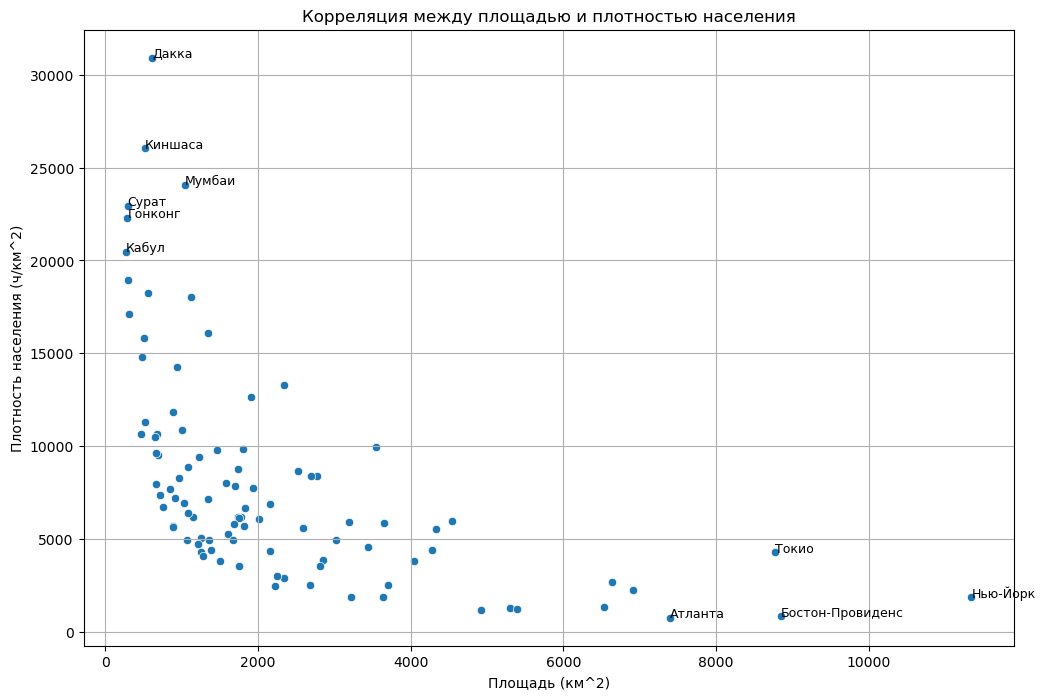

In [282]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Площадь (км^2)', y='Плотность населения (ч/км^2)', data=data)
plt.title('Корреляция между площадью и плотностью населения')
plt.xlabel('Площадь (км^2)')
plt.ylabel('Плотность населения (ч/км^2)')
plt.grid(True)
for i, row in data.iterrows():
    if row['Площадь (км^2)'] > 7000 or row['Плотность населения (ч/км^2)'] > 20000:
        plt.text(row['Площадь (км^2)'], row['Плотность населения (ч/км^2)'], row['Город'], fontsize=9)
plt.show()

На графике прослеживается нисходящий тренд, что соответствует отрицательной корреляции.

Кроме того, проведем аналитику зависимости при помощи Линейной регрессии:

In [285]:
X = data['Площадь (км^2)']
y = data['Плотность населения (ч/км^2)']

#Строим модель
model = sm.OLS(y, X).fit()

coeff = model.params
print("Коэффициенты регрессии:")
print(coeff)

Коэффициенты регрессии:
Площадь (км^2)   1.25
dtype: float64


Полученный коэффициент регрессии означает, что при увеличении площади на 1 квадратный километр, 
плотность населения уменьшается на 1.25 человека на квадратный километр. Таким образом, наша гипотеза подтвердилась.

**Гипотеза 2:** Страны, которые чаще всего встречаются в списке, имеют в среднем большую плотность населения по городам.
Для того чтобы проверить гипотезу, построим график, который будет отражать информацию как о средней плотности по стране, так и о количестве вхождений страны в рейтинг:

C:\Users\boris\AppData\Local\Temp\ipykernel_20100\3938182717.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



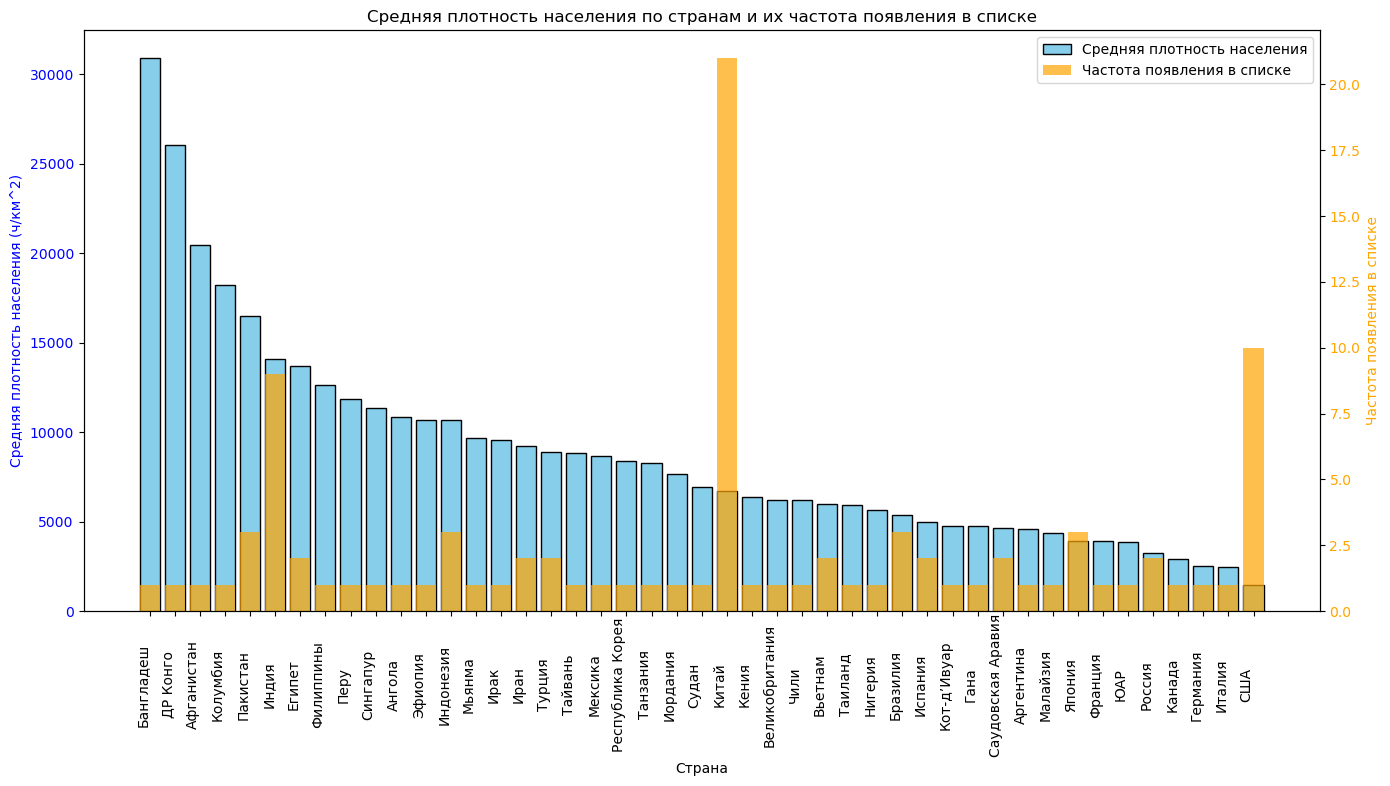

In [293]:
country_count = data['Страна'].value_counts()
country_avg_density = data.groupby('Страна')['Плотность населения (ч/км^2)'].mean()
country_avg_density_sorted = country_avg_density.sort_values(ascending=False)

#Сортируем частоту появления стран в том же порядке, что и среднюю плотность населения
country_count_sorted = country_count.loc[country_avg_density_sorted.index]

#Создаем график
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.bar(country_avg_density_sorted.index, country_avg_density_sorted.values, color='skyblue', edgecolor='black', label='Средняя плотность населения')

#Добавляем вторую ось, чтобы отразить частоту появления стран в списке
ax2 = ax1.twinx()
ax2.bar(country_count_sorted.index, country_count_sorted.values, color='orange', alpha=0.7, label='Частота появления в списке')

ax1.set_xlabel('Страна')
ax1.set_ylabel('Средняя плотность населения (ч/км^2)', color='blue')
ax2.set_ylabel('Частота появления в списке', color='orange')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')
ax1.set_title('Средняя плотность населения по странам и их частота появления в списке')
ax1.set_xticklabels(country_avg_density_sorted.index, rotation=90, ha='right', va='center', y=-0.11)

#Легенда
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

Мы получили интересный результат! Желтые столбцы, которые отражают частоту появления страны в списке, не совпадают с синими, которые отражают среднюю плотность. То есть то, как много в стране городов с высоким населением, не связано со средней плотностью населения в этой стране (по городам из топ-100). Этот эффект может возникнуть из-за того, что у многих стран единственный сильно населенный город - это столица. Поэтому с точки зрения средней плотности лидирует Бангладеш с единственным городом-столицей Дакка. А вот Китай, большая страна с развитой экономикой, по средней плотности находится в середине, но зато упоминается в списке наибольшее количество раз.

Убедиться в таком выводе можно, составив гистограмму плотностей населения по странам:

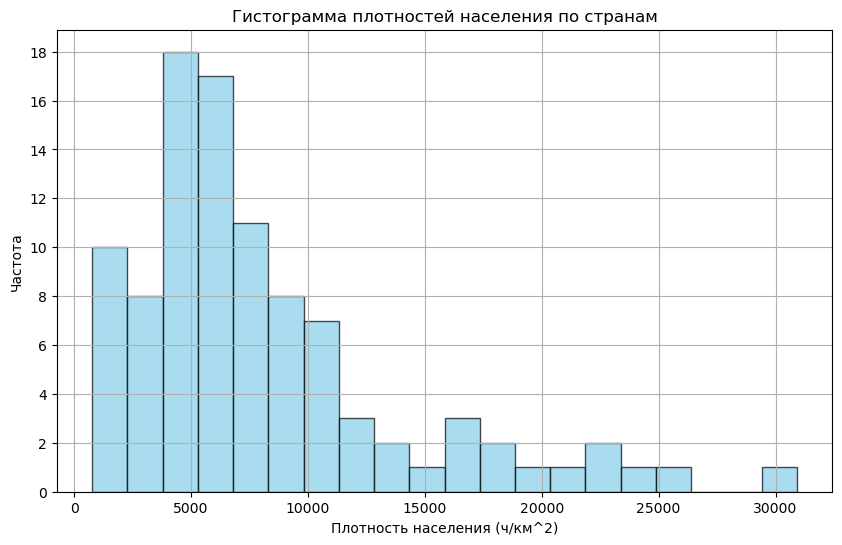

In [294]:
plt.figure(figsize=(10, 6))
plt.hist(data['Плотность населения (ч/км^2)'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Гистограмма плотностей населения по странам')
plt.xlabel('Плотность населения (ч/км^2)')
plt.ylabel('Частота')
plt.grid(True)

#Целые числа на оси Y
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

Гистограмма отражает количество стран, которые попадают в интервал плотности населения. Мы видим, что наибольшее
количество находится в интервале 0-10000, а дальше количество резко падает. Таким образом, гипотеза о том, что 
страны, которые чаще всего встречаются в списке, имеют в среднем большую плотность населения по городам, опровергнута.

**Гипотеза 3:** Наибольшее число стран из списка находятся в Азии. Чтоюы проверить эту гипотезу, изобразим на карте мира города из нашего списка. Для этого воспользуемся библиотеками geopy, для получения координат городов, и folium, для создания карты.

У некоторых городов даны несколько названий, которые идут через "-". Оставим только первый из вариантов:

In [238]:
data['Город'] = data['Город'].apply(lambda x: x.split('—')[0].strip())

Теперь переходим к сопоставлению городов с их координатами:

In [256]:
#Создаем функцию для получения координат
geolocator = Nominatim(user_agent="city_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coordinates(city, country):
    location = geocode(f"{city}, {country}")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

#Применяем функцию ко всем строкам DataFrame
data[['Широта', 'Долгота']] = data.apply(lambda row: pd.Series(get_coordinates(row['Город'], row['Страна'])), axis=1)


Три города не смэтчились с их координатами, но это не повлияет на качество анализа при проверке количества городов на целом континенте. Удалим пропущенные варианты:

In [257]:
data_new = data.dropna(subset=['Широта', 'Долгота'])

Теперь создаем карту. Чтобы была возможность посмотреть ее, нужно октрыть файл в блокноте:

In [214]:
m = folium.Map(location=[20, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(m)

#Добавляем точки
for idx, row in data_new.iterrows():
    folium.Marker([row['Широта'], row['Долгота']],
                  popup=f"{row['Город']}, {row['Страна']}<br>Население: {row['Население']}<br>Площадь: {row['Площадь (км^2)']} км^2<br>Плотность: {row['Плотность населения (ч/км^2)']} ч/км^2").add_to(marker_cluster)

m

У нас получилась интерактивная карта! Вы можете передвигаться по ней, выбирать интересующие города, нажимать на них и смотреть информацию. Если уменьшить карту, то города группируются сильнее, если увеличить, то постепенно можно дойти до каждого конкретного города. Кроме того, Гипотеза 3 подтверждена - 64 из 97 городов с самым большим населением находятся в Азии!

Теперь поработаем с SQL. **Гипотеза 4:** Среди городов, площадь которых больше средней площади всех из списка, больше всего городов США. Для того чтобы проверить, уберем в названиях столбцов пробелы:

In [296]:
data_new = data.rename(columns={
    'Город': 'Город',
    'Страна': 'Страна',
    'Население': 'Население',
    'Площадь (км^2)': 'Площадь',
    'Плотность населения (ч/км^2)': 'Плотность'
})

Теперь подключимся к базе данных SQLite и напишем запрос, который поможет проверить гипотезу:

In [298]:
#Подключение к базе данных SQLite
conn = sqlite3.connect('database.db')

#Записываем данные из DataFrame в базу данных SQLite
data_new.to_sql('mytable', conn, if_exists='replace', index=False)

#SQL-запрос
sql_query = """SELECT Город, Страна, Площадь
FROM mytable
WHERE Площадь > (SELECT AVG(Площадь) FROM mytable)
ORDER BY Площадь DESC"""

#Выполняем запроса
result = pd.read_sql(sql_query, conn)

print(result)
conn.close()

               Город            Страна  Площадь
0           Нью-Йорк               США    11344
1   Бостон-Провиденс               США     8847
2              Токио            Япония     8775
3            Атланта               США     7402
4       Лос-Анджелес               США     6918
5             Москва            Россия     6643
6             Чикаго               США     6532
7            Хьюстон               США     5390
8             Даллас               США     5307
9        Филадельфия               США     4916
10          Гуанчжоу             Китай     4543
11            Шанхай             Китай     4333
12             Пекин             Китай     4284
13      Йоханнесбург               ЮАР     4040
14             Нагоя            Япония     3704
15         Сан-Паулу          Бразилия     3649
16     Сан-Франциско               США     3634
17          Джакарта         Индонезия     3546
18      Буэнос-Айрес         Аргентина     3437
19            Майами               США  

Гипотеза 4 подтверждена! США богаты большим количеством мегаполисов, и неудивительно, что именно эта страна лидирует по площади городов. Давайте проверим еще одну гипотезу с помощью SQL. 
**Гипотеза 5:** Возьмем страны, которые встречаются в списке 3 раза или более. Теперь у этих стран найдем среднюю плотность по всем городам, а также найдем среднюю плотность среди всех этих стран. Страны, средняя плотность которых больше общей средней плотности, - это страны Азии.

In [299]:
conn = sqlite3.connect('database.db')
data_new.to_sql('mytable', conn, if_exists='replace', index=False)

#SQL-запрос
sql_query = """WITH плотность_страны AS (
    SELECT Страна AS страна, 
           COUNT(*) AS количество, 
           AVG(Плотность) AS средняя_плотность
    FROM mytable
    GROUP BY страна
    HAVING количество >= 3
),
общ_сред_плотность AS (
    SELECT AVG(средняя_плотность) AS общ_сред_плотность
    FROM плотность_страны
)
SELECT страна, средняя_плотность
FROM плотность_страны, общ_сред_плотность
WHERE плотность_страны.средняя_плотность > общ_сред_плотность.общ_сред_плотность"""

result = pd.read_sql(sql_query, conn)
print(result)
conn.close()

      страна  средняя_плотность
0      Индия           14084.33
1  Индонезия           10654.67
2   Пакистан           16463.33


Мы получили три страны, каждая из которых находится в Азии. Таким образом, Гипотеза 5 подтвердилась!
Проверим финальную гипотезу. **Гипотеза 6:** Города, расположенные ближе к экватору, имеют большую плотность населения по сравнению с городами, расположенными дальше от экватора. Это может быть обусловлено более привлекательными климатическими условиями (более теплым климатом), и более долгой историей урбанизации. Добавим колонку Расстояние до Экватора, то есть возьмем широту по модулю:

In [276]:
data.loc[:, 'Расст_до_Экватора'] = data_new['Широта'].apply(lambda x: abs(x))

Изобразим на мировой карте города. Те, которые дальше 23.5 градусов от экватора, обозначим зелеными точками, остальные синими. Нажав на точку, можно увидеть плотность населения в этом городе:

In [300]:
data = data.dropna(subset=['Широта', 'Долгота'])

# Создаем карту с центром на экваторе и нулевом меридиане
m = folium.Map(location=[0, 0], zoom_start=2)

# Добавляем точки
for _, row in data.iterrows():
    folium.CircleMarker(
        location=[row['Широта'], row['Долгота']],
        radius=5,
        popup=folium.Popup(f"{row['Город']}, {row['Страна']}<br>Плотность населения: {row['Плотность населения (ч/км^2)']}<br>Расстояние до экватора: {row['Расст_до_Экватора']:.2f} градусов"),
        color='blue' if row['Расст_до_Экватора'] < 23.5 else 'green', # Синий для городов в тропиках, зеленый для остальных
        fill=True,
        fill_color='blue' if row['Расст_до_Экватора'] < 23.5 else 'green'
    ).add_to(m)

#Мини-карта
mini_map = plugins.MiniMap(toggle_display=True)
m.add_child(mini_map)

m

Теперь изобразим города на точечном графике, который покажет зависимость плотности населения от расстояния до Экватора, и посчитаем коэффициент корреляции Пирсона и p-значение:

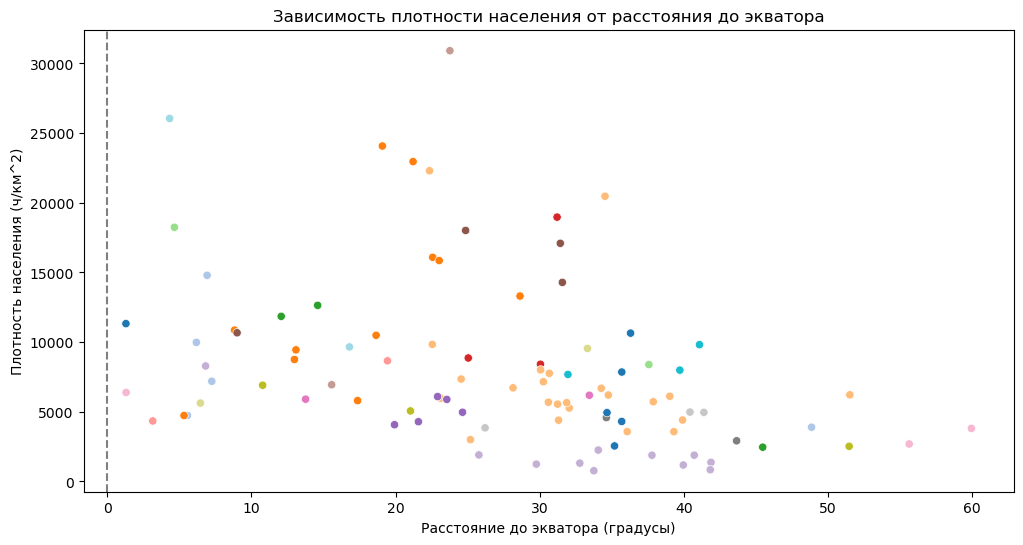

In [303]:
plt.figure(figsize=(12, 6))

sns.scatterplot(data=data, x='Расст_до_Экватора', y='Плотность населения (ч/км^2)', hue='Страна', palette='tab20', legend=None)

plt.title('Зависимость плотности населения от расстояния до экватора')
plt.xlabel('Расстояние до экватора (градусы)')
plt.ylabel('Плотность населения (ч/км^2)')
plt.axvline(0, color='grey', linestyle='--')

plt.show()

In [274]:
# Вычисляем коэффициент корреляции Пирсона и p-значение
correlation, p_value = pearsonr(data['Расст_до_Экватора'], data['Плотность населения (ч/км^2)'])
print(f'Коэффициент корреляции: {correlation}, p-значение: {p_value}')

Коэффициент корреляции: -0.36117301451637324, p-значение: 0.00027850165048391885


Таким образом, между расстоянием до Экватора и плотностью населения есть слабая отрицательная корреляция. Малое p-значение говорит о том, что корреляция статистически значима. Гипотеза 6 частично подтвердилась. На этом всё! Мы смогли проанализировать параметры ста самых населенных городских агломераций мира. Спасибо за внимание!